In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transform
from torchvision.transforms import ToTensor

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np

import subprocess
import glob
from moviepy.editor import VideoFileClip

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

from PIL import Image
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [127]:
# We use CUDA if possible
cuda = torch.cuda.is_available()
print("CUDA is available:", cuda)
device = torch.device('cuda' if cuda else 'cpu')

CUDA is available: True


In [ ]:
embedding_dimensionality = 2

### First we create the dataset

Implementation made following https://github.com/adambielski/siamese-triplet

In [128]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
        
        if len(img1.shape) > 2:
            img1 = Image.fromarray(np.uint8(img1.permute(1, 2, 0).numpy() * 255))
            img2 = Image.fromarray(np.uint8(img2.permute(1, 2, 0).numpy() * 255))
        else:
            # In the case of the MNIST dataset image was already in range [0-255]
            img1 = Image.fromarray(img1.numpy(), mode='L')
            img2 = Image.fromarray(img2.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)
    
### HYPERPARAMETERS
train_set = 'MIT_SPLIT'

print('Training set is:', train_set)
root_dir = '../datasets/' + train_set

train_data_dir= root_dir + '/train'
val_data_dir= root_dir + '/test'
test_data_dir= root_dir + '/test'

img_width = 224
img_height=224


### CREATE DATASET
transformation_train = transform.Compose([
    # you can add other transformations in this list
    # transform.RandomRotation(90),
    # transform.RandomHorizontalFlip(),
    # transform.RandomVerticalFlip(),
    ToTensor()
])

# No need to use data augmentation in validation
transformation_val = transform.Compose([
    # you can add other transformations in this list
    ToTensor()
])

batch_size = 8

train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transformation_train)
valid_dataset = torchvision.datasets.ImageFolder(root=test_data_dir,  transform=transformation_val)

original_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# We need to fill some attributes for the SiameseDataset class
train_dataset.train = True
valid_dataset.train = False

train_dataset.train_labels = torch.from_numpy(np.array(train_dataset.targets))
valid_dataset.test_labels = torch.from_numpy(np.array(valid_dataset.targets))

train_dataset.train_data = torch.from_numpy(np.array([s[0].numpy() for s in train_dataset]))
valid_dataset.test_data = torch.from_numpy(np.array([s[0].numpy() for s in valid_dataset]))


inv_class_to_idx = {v: k for k, v in train_dataset.class_to_idx.items()}

print(train_dataset.class_to_idx)
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)

siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(valid_dataset)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

Training set is: MIT_SPLIT
{'Opencountry': 0, 'coast': 1, 'forest': 2, 'highway': 3, 'inside_city': 4, 'mountain': 5, 'street': 6, 'tallbuilding': 7}
torch.Size([1881, 3, 256, 256])
torch.Size([1881])


In [129]:
mnist_classes = train_dataset.classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, title='', save_name='', xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    plt.title(title)
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes, loc="upper right")
    if save_name != '':
        plt.savefig(f'./outputs_task_b/{save_name}')
        plt.close()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

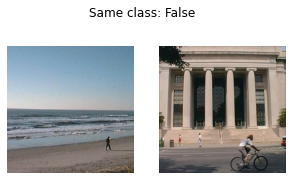

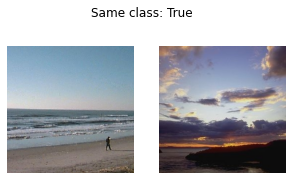

In [130]:
idx = 500
%matplotlib inline

(img1, img2), target = siamese_train_dataset[idx]
plt.figure(figsize=(5,3))
plt.suptitle(f'Same class: {target==1}')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2.permute(1, 2, 0).numpy())
plt.show()

(img1, img2), target = siamese_train_dataset[idx]
plt.figure(figsize=(5,3))
plt.suptitle(f'Same class: {target==1}')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2.permute(1, 2, 0).numpy())
plt.show()

### Now we create our Siamese Neural Network

In [131]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        # Change for one channel instead of 3 if input is grayscale
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(238144, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [132]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [133]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [187]:
margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 30
log_interval = 100

In [188]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError


class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [190]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0, save_gif=False):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    train_losses = []
    val_losses = []
    
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
        
        # Test stage
        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)
        
        if save_gif:
            train_embeddings_cl, train_labels_cl = extract_embeddings(original_train_loader, model)
            plot_embeddings(train_embeddings_cl, train_labels_cl, title='Train embeddings', save_name=f'train_embedding_{str(epoch).zfill(3)}.png')
            val_embeddings_cl, val_labels_cl = extract_embeddings(original_test_loader, model)
            plot_embeddings(val_embeddings_cl, val_labels_cl, title='Test embeddings', save_name=f'test_embedding_{str(epoch).zfill(3)}.png')
    
    return train_losses, val_losses


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()

    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

train_losses, val_losses = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, save_gif=True)

Train: [0/1881 (0%)]	Loss: 0.046730
Train: [800/1881 (42%)]	Loss: 0.060758
Train: [1600/1881 (85%)]	Loss: 0.066286
Epoch: 1/30. Train set: Average loss: 0.0639
Epoch: 1/30. Validation set: Average loss: 0.0979
Train: [0/1881 (0%)]	Loss: 0.116581
Train: [800/1881 (42%)]	Loss: 0.061377
Train: [1600/1881 (85%)]	Loss: 0.067487
Epoch: 2/30. Train set: Average loss: 0.0649
Epoch: 2/30. Validation set: Average loss: 0.0967
Train: [0/1881 (0%)]	Loss: 0.016131
Train: [800/1881 (42%)]	Loss: 0.060826
Train: [1600/1881 (85%)]	Loss: 0.061845
Epoch: 3/30. Train set: Average loss: 0.0614
Epoch: 3/30. Validation set: Average loss: 0.0961
Train: [0/1881 (0%)]	Loss: 0.063796
Train: [800/1881 (42%)]	Loss: 0.060240
Train: [1600/1881 (85%)]	Loss: 0.060950
Epoch: 4/30. Train set: Average loss: 0.0603
Epoch: 4/30. Validation set: Average loss: 0.0979
Train: [0/1881 (0%)]	Loss: 0.099704
Train: [800/1881 (42%)]	Loss: 0.057014
Train: [1600/1881 (85%)]	Loss: 0.055637
Epoch: 5/30. Train set: Average loss: 0.0571


In [191]:
print(train_losses)
print(val_losses)

[0.06387545707461945, 0.06488737370424225, 0.06135892707033683, 0.060332033544447335, 0.057126139381395304, 0.05951223049265474, 0.053276045528098434, 0.05607709854099331, 0.05282524935664388, 0.0557370317381633, 0.05402050119572145, 0.054295998330078074, 0.055339175357357044, 0.054071157685307375, 0.05174878964662331, 0.05207006033644143, 0.052847645281009, 0.05118494927271475, 0.05161843307205807, 0.05311966958550452, 0.05713690626356056, 0.05484535129567198, 0.053136697125826346, 0.05100667089523779, 0.051662871010317385, 0.051955086538189296, 0.05419282365187813, 0.05495887804555438, 0.05285710410927264, 0.054852249276413884]
[0.09792349628624644, 0.09674516430880764, 0.09612293675136153, 0.09786767857656399, 0.09656980190896383, 0.09633348904098246, 0.09573167379447582, 0.0957389856495037, 0.09693741184972816, 0.09531518651200181, 0.0960300284055163, 0.09710982067528928, 0.0969304266284303, 0.09697385972808345, 0.09681351612192939, 0.09682819903782099, 0.09668047329189607, 0.09657

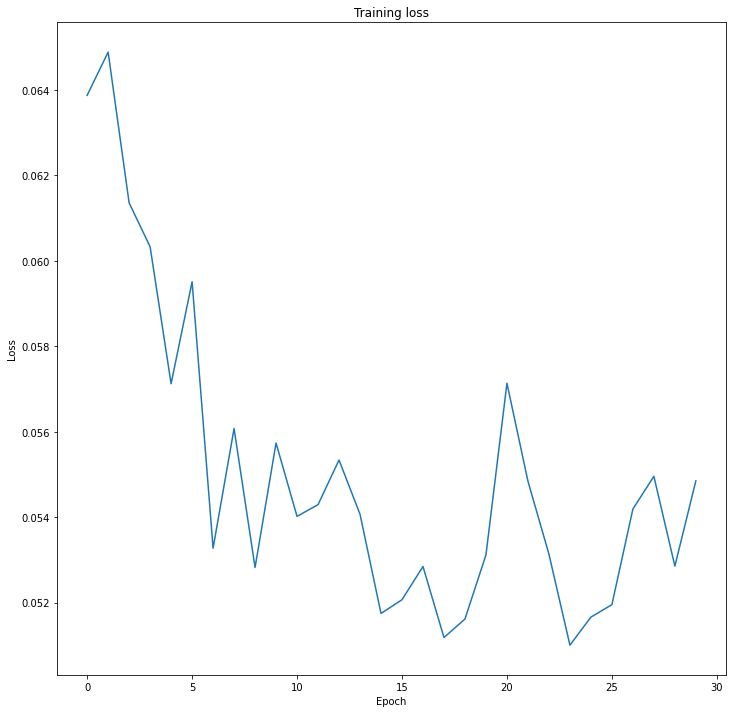

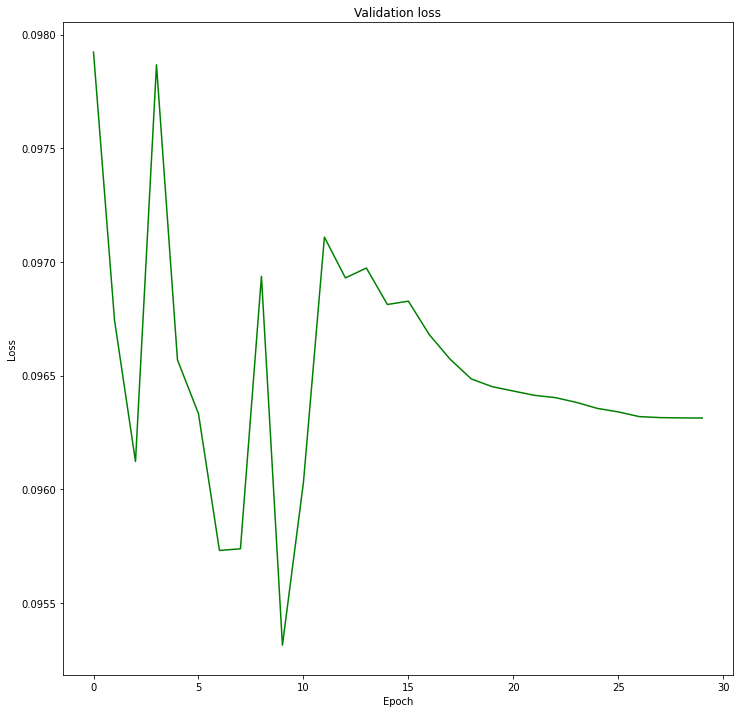

In [197]:
plt.figure(figsize=(12,12))
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.figure(figsize=(12,12))
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(val_losses, color='g')

Save training gif

In [137]:
parsed_filename = 'siamese_train_embedding_gif'

if os.path.isfile('./outputs_task_b/%s.mp4'%parsed_filename):
                os.remove('./outputs_task_b/%s.mp4'%parsed_filename)

os.chdir('./outputs_task_b')

try:
    subprocess.check_output(['ffmpeg', '-y', '-framerate', '1', '-i', 'train_embedding_%03d.png', '-r', '30', '-pix_fmt', 'yuv420p','%s.mp4'%parsed_filename],
                            shell=True,stderr=subprocess.STDOUT)
except Exception as e:
    raise RuntimeError("{}".format(e.output))

os.chdir('../')

for file_name in glob.glob('./outputs_task_b/train_embedding_*.png'):
    os.remove(file_name)

videoClip = VideoFileClip('./outputs_task_b/%s.mp4'%parsed_filename)
videoClip.write_gif('./outputs_task_b/%s.gif'%parsed_filename, fps=3)
videoClip.close()

MoviePy - Building file ./outputs_task_b/siamese_train_embedding_gif.gif with imageio.


In [138]:
parsed_filename = 'siamese_test_embedding_gif'

if os.path.isfile('./outputs_task_b/%s.mp4'%parsed_filename):
                os.remove('./outputs_task_b/%s.mp4'%parsed_filename)

os.chdir('./outputs_task_b')

try:
    subprocess.check_output(['ffmpeg', '-y', '-framerate', '1', '-i', 'test_embedding_%03d.png', '-r', '30', '-pix_fmt', 'yuv420p','%s.mp4'%parsed_filename],
                            shell=True,stderr=subprocess.STDOUT)
except Exception as e:
    raise RuntimeError("{}".format(e.output))

os.chdir('../')

for file_name in glob.glob('./outputs_task_b/test_embedding_*.png'):
    os.remove(file_name)

videoClip = VideoFileClip('./outputs_task_b/%s.mp4'%parsed_filename)
videoClip.write_gif('./outputs_task_b/%s.gif'%parsed_filename, fps=3)
videoClip.close()

MoviePy - Building file ./outputs_task_b/siamese_test_embedding_gif.gif with imageio.


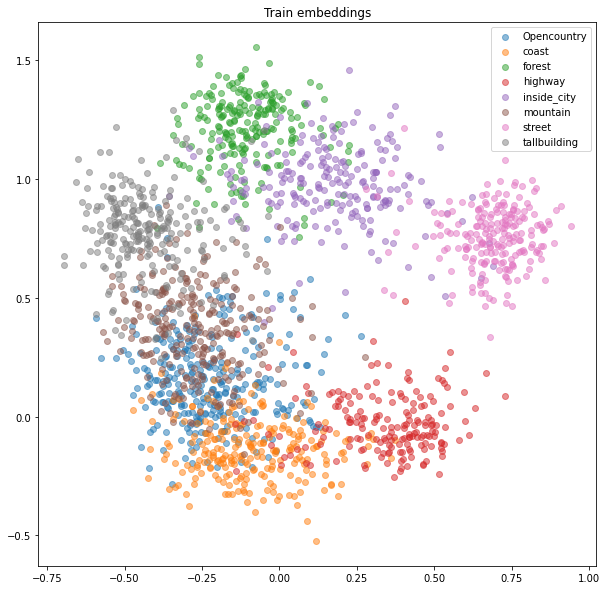

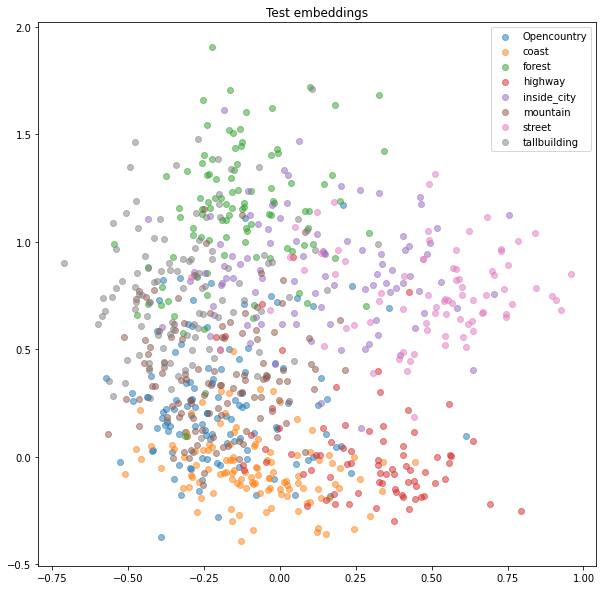

In [139]:
train_embeddings_cl, train_labels_cl = extract_embeddings(original_train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl, title='Train embeddings')
val_embeddings_cl, val_labels_cl = extract_embeddings(original_test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl, title='Test embeddings')

Lets run this on KNN

In [198]:
from sklearn.neighbors import KNeighborsClassifier


# storing the image representations
im_indices = []
im_representations = []
embeddings_indexed = []
labels_indexed = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(original_train_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model.get_embedding(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()
            label = label.cpu().numpy()
            embedding = embeddings[idx]
            im_indices.append(mnist_classes[label])
            im_representations.append(im)
            embeddings_indexed.append(embedding)
            labels_indexed.append(label)
            
embeddings_indexed = np.array(embeddings_indexed)
labels_indexed = np.array(labels_indexed)

knn = KNeighborsClassifier(n_neighbors=5).fit(embeddings_indexed, labels_indexed)

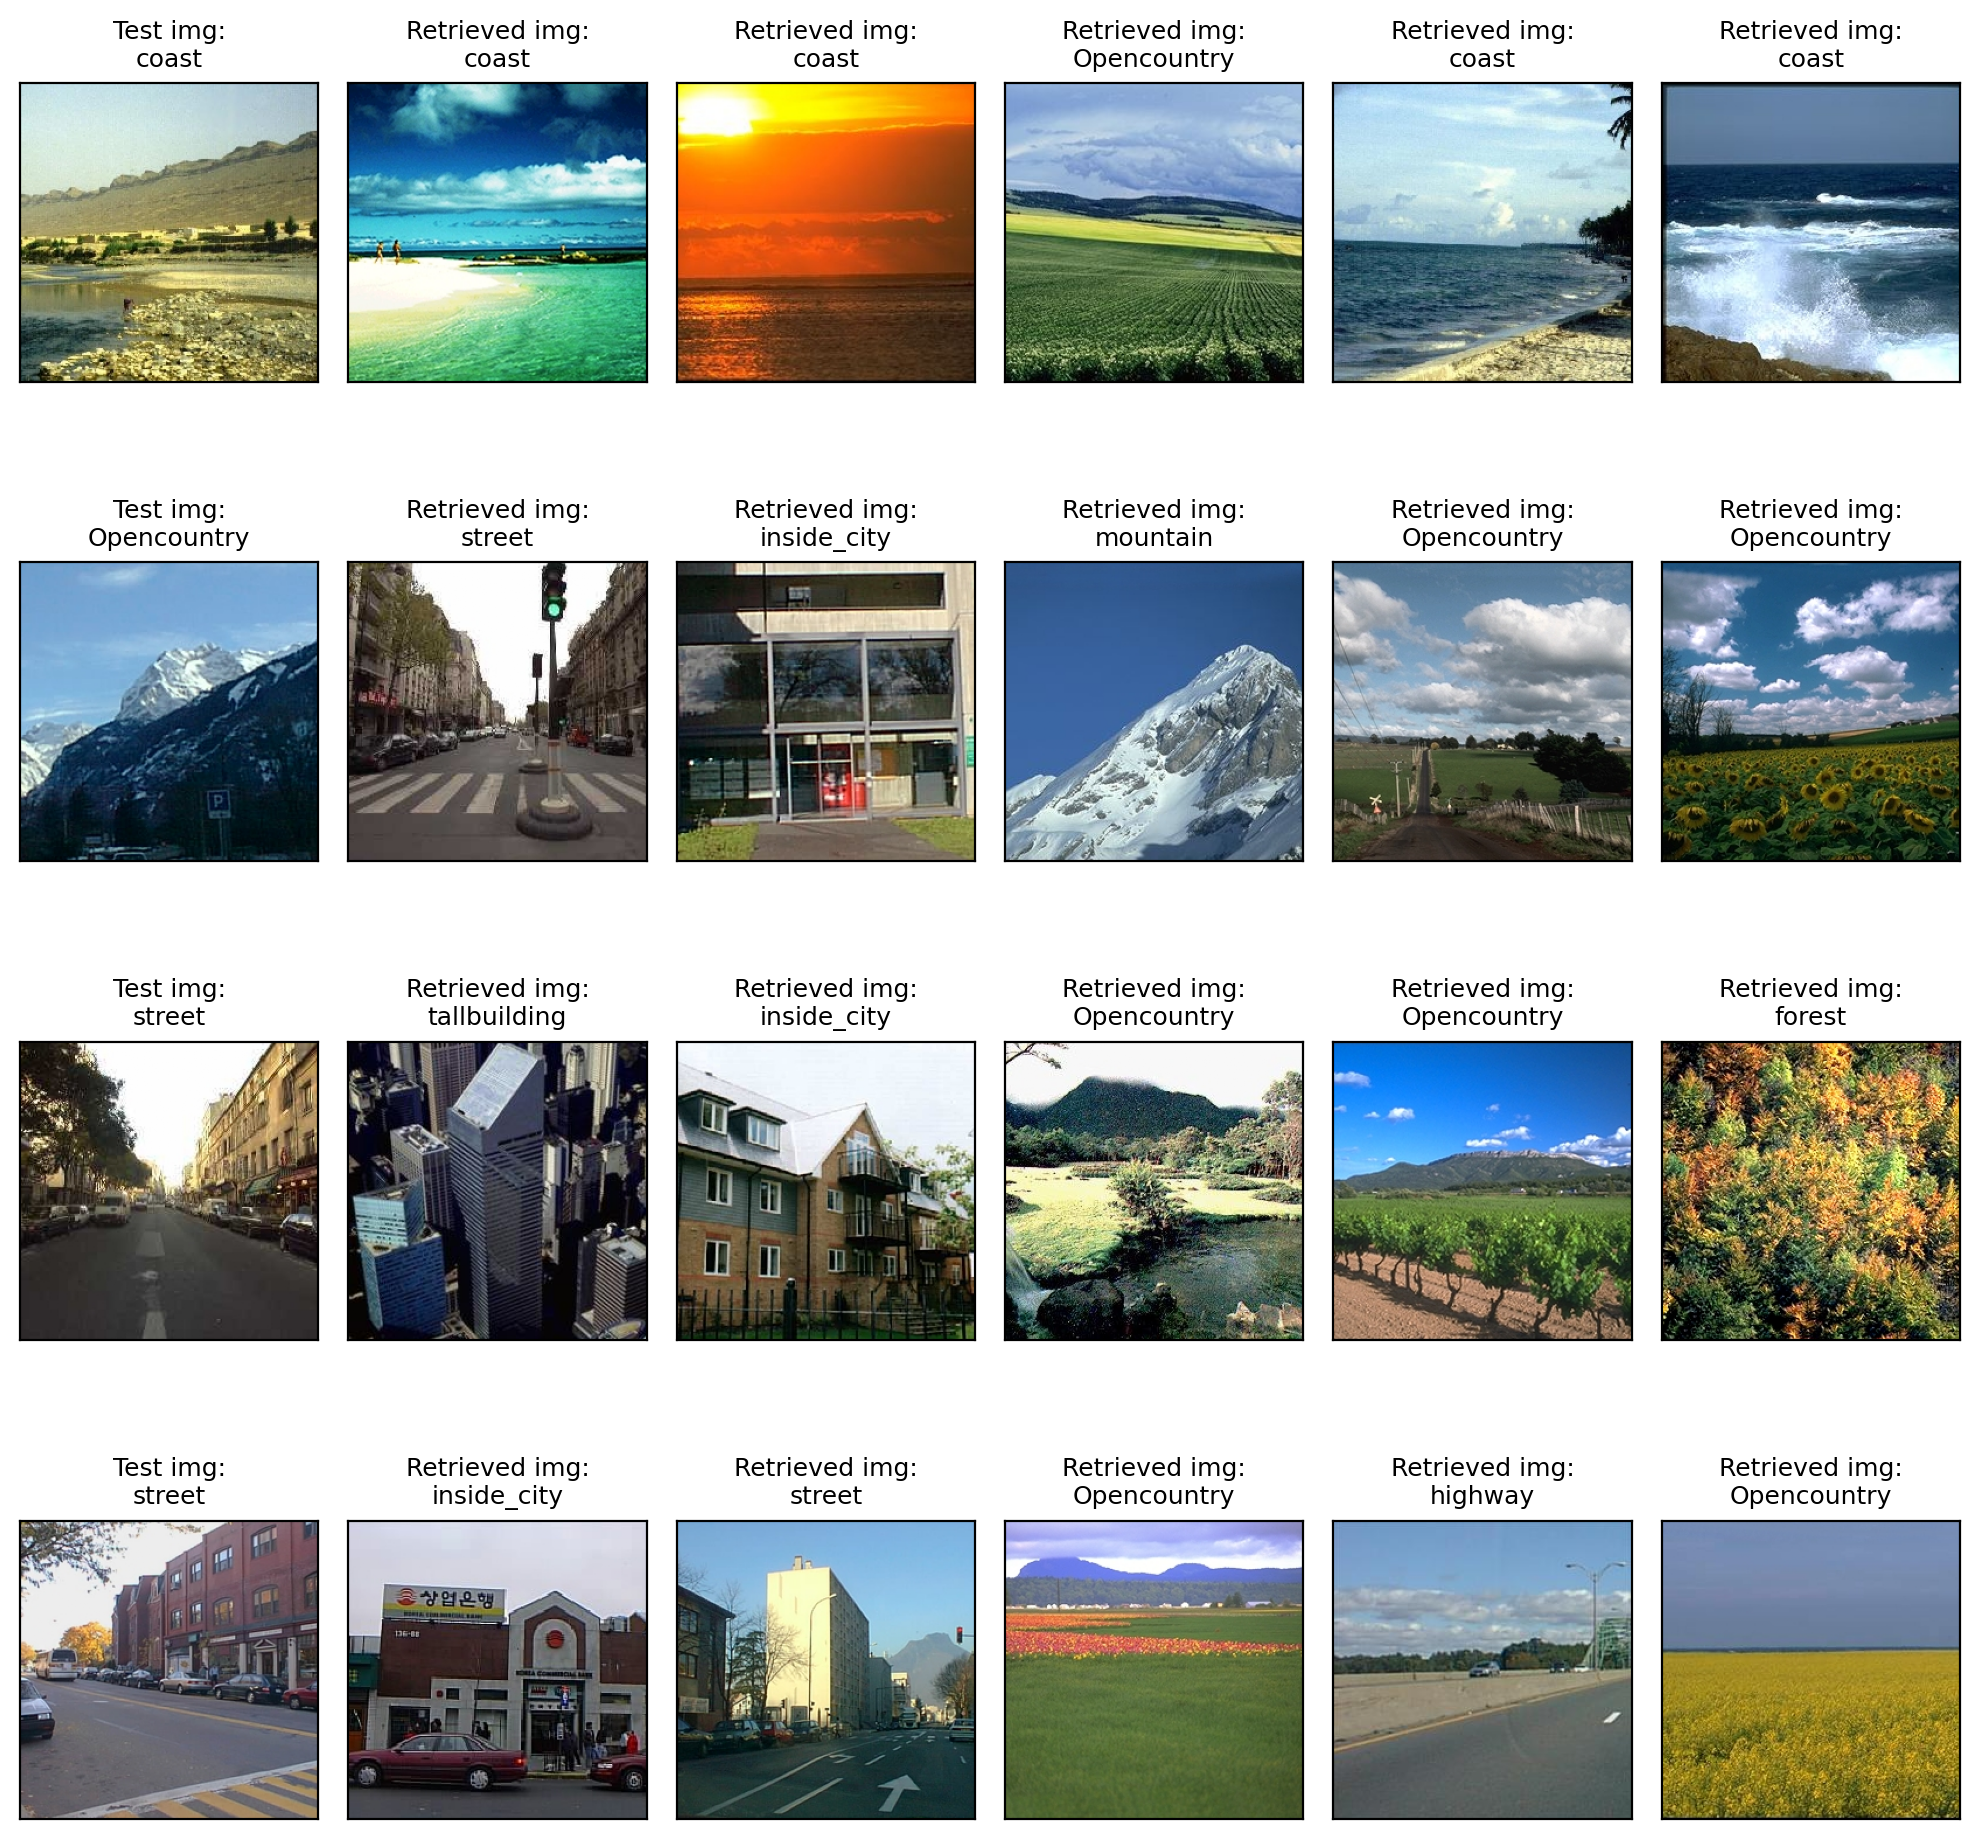

In [231]:
num_examples_to_show = 4
curr_im_idx = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(original_test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model.get_embedding(data).cpu().numpy()
        
        fig, ax = plt.subplots(num_examples_to_show, 6, figsize=(10, 10), dpi=200)
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            # If you want to test grayscale use
            # im = im.permute(0, 1, 2).cpu().numpy()
            im = im.permute(0, 1, 2).cpu().numpy()
            label = label.cpu().numpy()
            embedding = embeddings[idx]           
            
            distances, neighboor_idxs = knn.kneighbors([embedding], n_neighbors=5, return_distance=True)
            predicted_class = knn.predict([embedding])[0]
            
            
            # Plot retrieval
            
            ax[idx][0].imshow(np.transpose(im, (1, 2, 0)))
            ax[idx][0].set_xticks([])
            ax[idx][0].set_yticks([])
            class_name = class_names[val_targets[i]]
            ax[idx][0].set_title("Test img:\n" + str(mnist_classes[np.uint8(predicted_class)]), fontsize=9)
            for j in range (0,5):
                ax[idx][j+1].imshow(np.transpose(im_representations[neighboor_idxs[0][j]], (1, 2, 0)))
                ax[idx][j+1].set_xticks([])
                ax[idx][j+1].set_yticks([])
                class_name = class_names[train_targets[indices[idx][j]]]
                ax[idx][j+1].set_title("Retrieved img:\n" + mnist_classes[labels_indexed[neighboor_idxs[0][j]]], fontsize=9)
            
            
            # plt.figure()
            # plt.title(f'Test image - predicted/label: {mnist_classes[predicted_class]}/{mnist_classes[label]}')
            # plt.imshow(np.transpose(im, (1, 2, 0)))
            # plt.show()
            
            # plt.figure(figsize=(20,3))
            # plt.suptitle('Retrieved 5 most similar images')
            
            # for i in range(5):
            #     plt.subplot(1, 5, i+1)
            #     plt.title('Distance: %f, label: %s' %(distances[0][i], mnist_classes[labels_indexed[neighboor_idxs[0][i]]]))
            #     plt.axis('off')
            #     plt.imshow(np.transpose(im_representations[neighboor_idxs[0][i]], (1, 2, 0)))
            
            # plt.tight_layout()
            # plt.show()
            
            curr_im_idx += 1
            
            if curr_im_idx >= num_examples_to_show:
                break
        if curr_im_idx >= num_examples_to_show:
                break
            
fig.tight_layout()
plt.show()
plt.close()

Lets calculate some metrics

In [218]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score

model = torch.load('./outputs_task_b/weights/siamese_150.pth')  # Load model weights
model.eval()  # Set model to evaluation mode


test_embeddings, test_labels = extract_embeddings(original_test_loader, model)
train_embeddings, train_labels = extract_embeddings(original_train_loader, model) 


k = 10 # number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_embeddings, train_labels)
distances, indices = knn.kneighbors(test_embeddings)

test_labels = np.uint8(test_labels)
train_labels = np.uint8(train_labels)

# Compute the evaluation metrics
APs = []
Precisions_at_1 = []
Precisions_at_5 = []

# Compute MAP
# Convert integer targets to binary targets
binary_test_labels = np.zeros((test_embeddings.shape[0], 8))
binary_test_labels[np.arange(test_embeddings.shape[0]), test_labels] = 1

binary_train_labels = np.zeros((test_embeddings.shape[0], 8))
binary_train_labels[np.arange(test_embeddings.shape[0])[:,None], train_labels[indices]] = 1

# Compute average precision 
for i in range(test_embeddings.shape[0]):
    AP = average_precision_score(binary_test_labels[i], binary_train_labels[i])
    APs.append(AP)

MAP = np.mean(APs)

for i, (dists, idxs, target) in enumerate(zip(distances, indices, test_labels)):
    # Compute the precision at 1
    if train_labels[idxs[0]] == target:
        Precisions_at_1.append(1.0)
    else:
        Precisions_at_1.append(0.0)

    # Compute the precision at 5
    Precisions_at_5 = []
    for idx, target in zip(indices, test_labels):
        hits = np.isin(train_labels[idx][:5], target)
        precision_at_5 = np.sum(hits) / 5.0
        Precisions_at_5.append(precision_at_5)

# Compute the precision at 1 and precision at 5
Prec_1 = np.mean(Precisions_at_1)
Prec_5 = np.mean(Precisions_at_5)
print('MAP:', MAP)
print('Prec@1:', Prec_1)
print('Prec@5:', Prec_5)

MAP: 0.44867823213548125
Prec@1: 0.5030978934324659
Prec@5: 0.49615861214374224


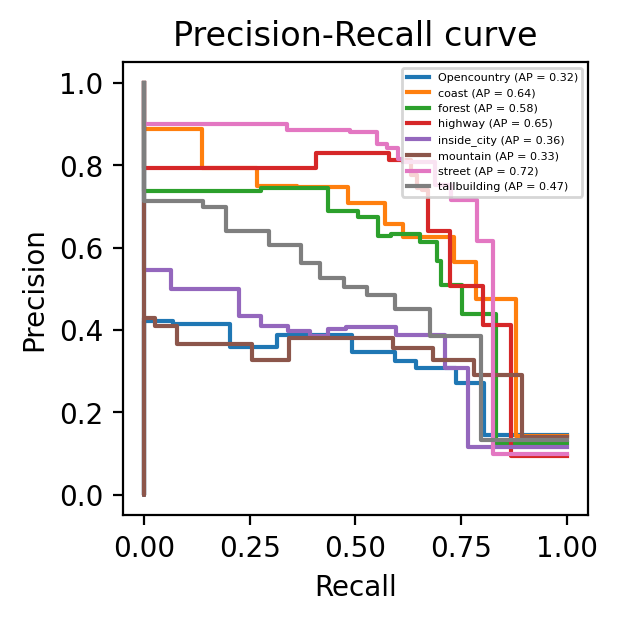

In [217]:
val_prob = knn.predict_proba(test_embeddings)
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=200)
ax.set_title("Precision-Recall curve", size=12)
for class_id, class_name in enumerate(class_names):
    PrecisionRecallDisplay.from_predictions(np.where(val_targets==class_id, 1, 0),
                                            val_prob[:, class_id],
                                            ax=ax, name=class_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right', prop={'size': 4})